In [1]:
from collections import Counter
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math

# Load data (example structure)
drugs = pd.read_csv("drug_smiles.csv")  # {Drug ID: SMILES}
proteins = pd.read_csv("pdb_sequences.csv")  # {PDB ID: Sequence}
interactions = pd.read_csv("confirmed_interactions.csv")  # {PDB ID: [Drug IDs]}

drugs_dict = drugs.set_index('Drug id')['smiles'].to_dict()  # Assuming these are your column names
proteins_dict = proteins.set_index('pdb_id')['sequence'].to_dict()

# Create dataset
drug_ids = list(drugs_dict.keys())
protein_ids = list(proteins_dict.keys())

positive_pairs = []
for _, row in interactions.iterrows():
        drug_id = row['Drug ID']  # Adjust column name if different
        pdb_id = row['PDB ID']    # Adjust column name if different
        
        # Verify the pair exists in our dictionaries
        if drug_id in drugs_dict and pdb_id in proteins_dict:
            positive_pairs.append((drug_id, pdb_id, 1))

# Create negative pairs more efficiently
negative_pairs = []
used_pairs = set((d, p) for d, p, _ in positive_pairs)
num_needed = len(positive_pairs)

# Use batch processing with progress tracking
from tqdm import tqdm
batch_size = 1000

with tqdm(total=num_needed, desc="Generating negative pairs") as pbar:
    while len(negative_pairs) < num_needed:
        # Generate multiple pairs at once
        batch_drugs = random.choices(drug_ids, k=batch_size)
        batch_proteins = random.choices(protein_ids, k=batch_size)
        
        for d, p in zip(batch_drugs, batch_proteins):
            if (d, p) not in used_pairs:
                negative_pairs.append((d, p, 0))
                used_pairs.add((d, p))
                pbar.update(1)
                
                if len(negative_pairs) >= num_needed:
                    break

# Verify the results
print(f"Number of positive pairs: {len(interactions)}")
print(f"Number of negative pairs: {len(negative_pairs)}")
print(f"Sample of negative pairs:\n{negative_pairs[:5]}")
dataset = positive_pairs + negative_pairs
random.shuffle(dataset)

# Split dataset (train/val/test as per paper: ~70/15/15)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
train_data, val_data, test_data = dataset[:train_size], dataset[train_size:train_size + val_size], dataset[train_size + val_size:]

Generating negative pairs: 100%|██████████| 968/968 [00:00<00:00, 716949.72it/s]

Number of positive pairs: 968
Number of negative pairs: 968
Sample of negative pairs:
[('DB08877', '1F0J', 0), ('DB13269', '3OC2', 0), ('DB09195', '1L2J', 0), ('DB13955', '3UVJ', 0), ('DB01073', '1YRK', 0)]


In [2]:
len(test_data)

291

In [3]:
import pandas as pd

# Load subsequence CSVs
drug_subseq_df = pd.read_csv("drug_smiles_fcs_freq_100.csv")  # e.g., columns: subsequence, rank
protein_subseq_df = pd.read_csv("protein_fcs_freq_100.csv")

# Build dictionaries
drug_vocab = dict(zip(drug_subseq_df["Subsequence"], drug_subseq_df["Rank"]))
protein_vocab = dict(zip(protein_subseq_df["Subsequence"], protein_subseq_df["Rank"]))

# Combine into single vocab with special tokens
vocab = {"[CLS]": 0, "[SEP]": 1, "[MASK]": 2, "[PAD]": 3, "[UNK]": 4}
vocab.update(drug_vocab)
# Fixed iteration over protein_vocab items
for subseq, rank in protein_vocab.items():  # Use .items() to iterate over key-value pairs
    if subseq not in vocab:
        vocab[subseq] = rank

In [4]:
len(vocab)

50507

In [5]:
drugs = pd.read_csv("drug_smiles.csv").set_index("Drug id")["smiles"].to_dict()  # {Drug ID: SMILES}
proteins = pd.read_csv("pdb_sequences.csv").set_index("pdb_id")["sequence"].to_dict()

In [6]:
def get_matching_subsequences(sequence, vocab_subset, min_len=2, max_len=6):
    """Extract subsequences from a sequence that match the vocabulary"""
    subsequences = []
    
    for length in range(min_len, min(max_len + 1, len(sequence) + 1)):
        for i in range(len(sequence) - length + 1):
            subseq = sequence[i:i + length]
            if subseq in vocab_subset:
                subsequences.append(subseq)
    
    # If no subsequences found, use special token
    if not subsequences:
        subsequences.append("[UNK]")
        
    return subsequences

# Process all sequences and build subsequence representations
print("Building subsequence representations...")
drug_representations = {}  # {drug_id: [subsequences]}
protein_representations = {}  # {pdb_id: [subsequences]}

for drug_id in drugs_dict:
    drug_seq = drugs_dict[drug_id]
    drug_representations[drug_id] = get_matching_subsequences(drug_seq, drug_vocab)

for pdb_id in proteins_dict:
    protein_seq = proteins_dict[pdb_id]
    protein_representations[pdb_id] = get_matching_subsequences(protein_seq, protein_vocab)

print(f"Processed {len(drug_representations)} drugs and {len(protein_representations)} proteins")

# Sample output
print("\nSample drug subsequences:", next(iter(drug_representations.values()))[:5])
print("Sample protein subsequences:", next(iter(protein_representations.values()))[:5])

Building subsequence representations...
Processed 300 drugs and 298 proteins

Sample drug subsequences: ['Nc', 'c1', '1n', 'nc', 'cn']
Sample protein subsequences: ['RH', 'HV', 'VR', 'RI', 'IK']


In [7]:
import torch

class DTISubsequenceTokenizer:
    """Wrapper around base tokenizer with subsequence-specific processing"""
    
    def __init__(self, base_tokenizer):
        self.tokenizer = base_tokenizer
        
        # Add special tokens for subsequence processing
        special_tokens = {
            "additional_special_tokens": ["[SUB]"]
        }
        
        # Add the tokens to the tokenizer
        num_added = self.tokenizer.add_special_tokens(special_tokens)
        print(f"Added {num_added} special tokens to the tokenizer")
        
        # Store token IDs for quick access
        self.sub_token_id = self.tokenizer.convert_tokens_to_ids("[SUB]")
        self.sep_token_id = self.tokenizer.sep_token_id
        self.cls_token_id = self.tokenizer.cls_token_id
        self.pad_token_id = self.tokenizer.pad_token_id
        
    def __call__(self, drug_text, protein_text, **kwargs):
        """Tokenize drug and protein texts with special handling for subsequences"""
        # Format input with special tokens
        text_pair = f"{drug_text}", f"{protein_text}"
        
        # Use the base tokenizer
        encoding = self.tokenizer(
            text_pair[0],
            text_pair[1],
            **kwargs
        )
        
        return encoding
    
    def convert_ids_to_tokens(self, ids):
        """Convert token IDs back to string tokens"""
        return self.tokenizer.convert_ids_to_tokens(ids)
    
    def batch_encode_plus(self, batch_text_pairs, **kwargs):
        """Batch encode multiple text pairs"""
        return self.tokenizer.batch_encode_plus(batch_text_pairs, **kwargs)
    
    # Forward all other methods to the base tokenizer
    def __getattr__(self, name):
        return getattr(self.tokenizer, name)

In [8]:
!pip install rdkit

In [9]:
import re
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys

class SubsequenceProcessor:
    """Extract meaningful subsequences from drugs and proteins"""
    
    def __init__(self):
        # Define common protein motifs and drug functional groups for matching
        self.protein_motifs = {
            'zinc_finger': r'C.{2,4}C.{3}[LIVMFYWC].{8}H.{3,5}H',
            'helix_turn_helix': r'[LIVMFYW].{2}[LIVMF].{8,10}[LIVMFYWC].{5}[LIVMF]',
            'binding_pocket': r'[RK].{2,4}[DE].{2,4}[RK]',
            'hydrophobic': r'[LIVMFYW]{3,}',
            'acidic': r'[DE]{2,}',
            'basic': r'[RK]{2,}',
            'phosphorylation': r'[ST]P',
            'glycosylation': r'N[^P][ST]'
        }
        
        # Common drug functional groups
        self.drug_functional_groups = [
            'C(=O)N',     # Amide
            'c1ccccc1',   # Benzene
            'C(=O)O',     # Carboxyl
            'CN',         # Amine
            'CO',         # Alcohol
            'C=O',        # Carbonyl
            'CS',         # Thiol
            'CF',         # Fluoro
            'CCl',        # Chloro
            'CBr',        # Bromo
            'CI',         # Iodo
            'C=C',        # Alkene
            'C#N',        # Nitrile
            'C#C',        # Alkyne
            'N=O',        # Nitro
            'c1ccncc1',   # Pyridine
            'c1cncnc1',   # Pyrimidine
            'c1cnccn1',   # Pyrazine
            'c1cnncc1',   # Pyridazine
        ]
    
    def extract_protein_subsequences(self, sequence, window_size=8, stride=4):
        """Extract protein subsequences using sliding window and motif matching"""
        subsequences = []
        
        # Add the whole sequence as a subsequence if it's short
        if len(sequence) <= window_size * 2:
            subsequences.append(sequence)
            return subsequences
            
        # Use sliding window to extract subsequences
        for i in range(0, len(sequence) - window_size + 1, stride):
            subsequences.append(sequence[i:i+window_size])
        
        # Extract known motifs using regex patterns
        for motif_name, pattern in self.protein_motifs.items():
            for match in re.finditer(pattern, sequence):
                motif_seq = match.group(0)
                if motif_seq not in subsequences:
                    subsequences.append(motif_seq)
        
        return subsequences
    
    def extract_drug_subsequences(self, smiles):
        """Extract meaningful subsequences from drug SMILES string"""
        subsequences = []
        
        # Add the original SMILES as a subsequence if it's short
        if len(smiles) < 20:
            subsequences.append(smiles)
        
        try:
            # Parse the SMILES string
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                # If parsing fails, return the original SMILES broken into chunks
                return [smiles[i:i+10] for i in range(0, len(smiles), 10)]
            
            # Get Morgan fingerprint as representation of functional groups
            fp = AllChem.GetMorganFingerprint(mol, 2)
            for bit_id, _ in fp.GetNonzeroElements().items():
                env = Chem.MolToSmiles(AllChem.GetMorganEnvFragment(mol, bit_id, 1))
                if env and len(env) <= 20:  # Reasonable size for a subsequence
                    subsequences.append(env)
            
            # Check for presence of common functional groups
            for fg in self.drug_functional_groups:
                patt = Chem.MolFromSmiles(fg)
                if mol.HasSubstructMatch(patt):
                    subsequences.append(fg)
                    
            # Extract ring systems
            for ring in Chem.GetSymmSSSR(mol):
                ring_smiles = Chem.MolToSmiles(Chem.PathToSubmol(mol, list(ring)))
                if ring_smiles and ring_smiles not in subsequences:
                    subsequences.append(ring_smiles)
                    
        except Exception as e:
            # If chemical parsing fails, use simple string-based chunking
            print(f"Error processing SMILES {smiles}: {str(e)}")
            subsequences = [smiles[i:i+10] for i in range(0, len(smiles), 10)]
        
        # Ensure we have at least some subsequences
        if not subsequences:
            subsequences = [smiles]
            
        return subsequences

class EnhancedDTIDataset(Dataset):
    def __init__(self, pairs, drugs_dict, proteins_dict, tokenizer, config):
        self.pairs = pairs
        self.drugs_dict = drugs_dict
        self.proteins_dict = proteins_dict
        self.tokenizer = tokenizer
        self.config = config
        
        # Process sequences in advance
        self.processed_data = []
        
        print("Pre-processing drug-protein pairs...")
        for drug_id, pdb_id, label in tqdm(pairs, desc="Processing dataset"):
            if drug_id in drugs_dict and pdb_id in proteins_dict:
                # Get SMILES and protein sequence
                smiles = drugs_dict[drug_id]
                sequence = proteins_dict[pdb_id]
                
                # Process sequences (add methods to extract subsequences if needed)
                processed_drug = self.process_drug(smiles)
                processed_protein = self.process_protein(sequence)
                
                # Tokenize with special tokens
                encoding = self.tokenize_pair(processed_drug, processed_protein)
                
                # Store processed data
                item = {
                    'drug_id': drug_id,
                    'pdb_id': pdb_id,
                    'input_ids': encoding['input_ids'],
                    'attention_mask': encoding['attention_mask'],
                    'token_type_ids': encoding.get('token_type_ids', None),
                    'labels': torch.tensor(label, dtype=torch.long)
                }
                
                self.processed_data.append(item)
        
        print(f"Processed {len(self.processed_data)} valid drug-protein pairs.")
    
    def process_drug(self, smiles):
        """Process drug SMILES string - can be enhanced with RDKit"""
        return smiles
    
    def process_protein(self, sequence):
        """Process protein sequence - can be enhanced with motif detection"""
        return sequence
    
    def tokenize_pair(self, drug, protein):
        """Tokenize drug-protein pair with appropriate special tokens"""
        # Format input with special tokens
        text_pair = (
            f"{drug}",
            f"{protein}"
        )
        
        # Tokenize
        encoding = self.tokenizer(
            text_pair[0],
            text_pair[1],
            padding='max_length',
            truncation='longest_first',
            max_length=self.config.max_seq_length,
            return_tensors='pt'
        )
        
        # Remove batch dimension
        for key in encoding:
            if isinstance(encoding[key], torch.Tensor):
                encoding[key] = encoding[key].squeeze(0)
        
        return encoding
    
    def __len__(self):
        return len(self.processed_data)
    
    def __getitem__(self, idx):
        return self.processed_data[idx]

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer

def initialize_weights(module):
    """Initialize transformer weights properly"""
    if isinstance(module, (nn.Linear, nn.Embedding)):
        # Slightly different initialization from PyTorch as BioBERT is from transformers
        module.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()
    elif isinstance(module, nn.LayerNorm):
        module.bias.data.zero_()
        module.weight.data.fill_(1.0)

class DTITransformerModel(nn.Module):
    def __init__(self, config, tokenizer):
        super(DTITransformerModel, self).__init__()
        self.tokenizer = tokenizer
        
        # BioBERT encoder for initial embeddings
        self.bert = AutoModel.from_pretrained(
            "dmis-lab/biobert-v1.1",
            add_pooling_layer=False,
            output_attentions=True
        )
        
        hidden_size = self.bert.config.hidden_size
        
        # Freeze BioBERT parameters except last N layers
        unfreeze_layers = 2  # Last 2 layers
        for name, param in self.bert.named_parameters():
            param.requires_grad = False
            # Unfreeze specified layers
            if any(f"encoder.layer.{str(11-i)}." in name for i in range(unfreeze_layers)):
                param.requires_grad = True
        
        # Positional embeddings
        self.position_embeddings = nn.Embedding(config.max_seq_length, hidden_size)
        self.register_buffer("position_ids", torch.arange(config.max_seq_length).expand((1, -1)))
        
        # Drug-protein type embeddings
        self.type_embeddings = nn.Embedding(2, hidden_size)
        
        # Layer normalization and dropout
        self.LayerNorm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(config.dropout_rate)
        
        # Transformer encoder (6 layers, 12 heads as per paper)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=config.num_attention_heads,
            dim_feedforward=config.intermediate_size,
            dropout=config.dropout_rate,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=config.num_encoder_layers
        )
        
        # FC layer (384 units as per paper)
        self.intermediate_dense = nn.Linear(hidden_size, config.fc_size)
        
        # Output classification layer
        self.classifier = nn.Linear(config.fc_size, config.num_classes)
        
        # Initialize weights properly
        self.apply(initialize_weights)
        
        # Count trainable parameters
        self.num_parameters = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Trainable parameters: {self.num_parameters:,}")
    
    def forward(self, input_ids, attention_mask, return_attentions=False):
        """Forward pass with improved stability"""
        # Get token embeddings from BioBERT
        with torch.set_grad_enabled(True):  # Ensure gradients even with frozen layers
            bert_outputs = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_attentions=return_attentions
            )
        
        token_embeddings = bert_outputs.last_hidden_state
        
        # Add positional embeddings
        seq_length = input_ids.size(1)
        position_ids = self.position_ids[:, :seq_length]
        position_embeddings = self.position_embeddings(position_ids)
        
        # Create drug-protein type IDs
        batch_size = input_ids.size(0)
        drug_protein_type_ids = torch.zeros_like(input_ids)
        
        # Use the tokenizer's sep_token_id for robustness
        sep_token_id = self.tokenizer.sep_token_id if hasattr(self.tokenizer, 'sep_token_id') else 102
        
        # Find drug-protein boundaries using [SEP] tokens
        for i in range(batch_size):
            sep_positions = (input_ids[i] == sep_token_id).nonzero(as_tuple=True)[0]
            if len(sep_positions) >= 1:
                first_sep = sep_positions[0]
                drug_protein_type_ids[i, first_sep+1:] = 1
        
        # Get type embeddings
        type_embeddings = self.type_embeddings(drug_protein_type_ids)
        
        # Combine embeddings 
        embeddings = token_embeddings + position_embeddings + type_embeddings
        
        # Apply layer norm and dropout
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        
        # Apply attention mask for transformer
        transformer_mask = attention_mask.float()
        transformer_mask = transformer_mask.masked_fill(transformer_mask == 0, float('-inf'))
        transformer_mask = transformer_mask.masked_fill(transformer_mask == 1, float(0.0))
        
        # Pass through transformer encoder with proper masking
        transformer_outputs = self.transformer_encoder(embeddings, src_key_padding_mask=(attention_mask == 0))
        
        # Extract [CLS] token representation for classification
        cls_output = transformer_outputs[:, 0]
        
        # Apply intermediate FC layer
        intermediate_output = self.intermediate_dense(cls_output)
        intermediate_output = F.gelu(intermediate_output)
        intermediate_output = self.dropout(intermediate_output)
        
        # Final classification
        logits = self.classifier(intermediate_output)
        
        if return_attentions:
            return logits, bert_outputs.attentions
        
        return logits
        
# Model configuration
class ModelConfig:
    def __init__(self):
        # Model architecture - Section 2.5.4
        self.hidden_size = 768           # BioBERT base hidden size
        self.intermediate_size = 1536    # "intermediate dimension of 1536"
        self.num_attention_heads = 12    # "12 attention heads to each encoder" 
        self.num_encoder_layers = 6      # "six hidden transformer encoder layers"
        self.fc_size = 384              # "the size of the final network of the FC layer is 384"
        
        # Model parameters
        self.num_classes = 2            # Binary classification
        self.max_seq_length = 512       # Maximum sequence length for tokenization
        
        # Subsequence parameters
        self.max_drug_subseqs = 20      # Maximum number of drug subsequences to use
        self.max_protein_subseqs = 40   # Maximum number of protein subsequences to use
        self.use_subseq_markers = True  # Whether to use subsequence marker tokens
        
        # Training parameters from the paper
        self.batch_size = 32            # "batch size... to 32"
        self.num_epochs = 100           # "number of epochs to 100" 
        self.learning_rate = 1e-5       # "learning rate... 1e-5"
        self.dropout_rate = 0.1         # "dropout rate are... 0.1"

In [11]:
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix

class Trainer:
    def __init__(self, model, config, train_loader, val_loader, device):
        self.model = model
        self.config = config
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
        # Initialize class weights for imbalance
        self.class_weights = self.compute_class_weights()
        self.class_weights = torch.tensor(self.class_weights, dtype=torch.float).to(device)
        
        # Loss function with focal loss for imbalanced data
        self.criterion = nn.CrossEntropyLoss(weight=self.class_weights)
        
        # Optimizer with weight decay and different LR for different parameter groups
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() 
                          if not any(nd in n for nd in no_decay) and p.requires_grad],
                "weight_decay": 0.01,
            },
            {
                "params": [p for n, p in model.named_parameters() 
                          if any(nd in n for nd in no_decay) and p.requires_grad],
                "weight_decay": 0.0,
            },
        ]
        
        self.optimizer = torch.optim.AdamW(
            optimizer_grouped_parameters,
            lr=config.learning_rate,
            eps=1e-8
        )
        
        # LR scheduler with warmup
        total_steps = len(train_loader) * config.num_epochs
        warmup_steps = int(0.1 * total_steps)  # 10% warmup
        
        from transformers import get_scheduler
        self.scheduler = get_scheduler(
            name="linear",
            optimizer=self.optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )
        
        # Save training history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_accuracy': [],
            'val_accuracy': [],
            'train_f1': [],
            'val_f1': [],
            'val_auc': []
        }
        
        # Best model state
        self.best_model_state = None
        self.best_val_f1 = 0.0
    
    def compute_class_weights(self):
        """Compute weights for class imbalance"""
        # Count samples per class
        class_counts = [0, 0]  # Binary classification
        
        for batch in self.train_loader:
            labels = batch['labels'].cpu().numpy()
            unique_labels, counts = np.unique(labels, return_counts=True)
            for label, count in zip(unique_labels, counts):
                class_counts[label] += count
        
        # Calculate balanced weights
        total = sum(class_counts)
        weights = [total / (len(class_counts) * count) if count > 0 else 1.0 
                  for count in class_counts]
        
        print(f"Class counts: {class_counts}")
        print(f"Class weights: {weights}")
        
        return weights
    
    def train_epoch(self, epoch):
        """Train for one epoch with stability improvements"""
        self.model.train()
        epoch_loss = 0.0
        all_preds = []
        all_labels = []
        
        # Use tqdm for progress bar
        train_iter = tqdm(self.train_loader, desc=f"Training Epoch {epoch+1}/{self.config.num_epochs}")
        
        for batch in train_iter:
            # Move to device
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            
            # Handle potential CUDA out of memory
            try:
                outputs = self.model(input_ids, attention_mask)
                loss = self.criterion(outputs, labels)
                
                # Backward pass with gradient clipping
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                self.optimizer.step()
                self.scheduler.step()
                
                # Collect metrics
                epoch_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # Update progress bar
                train_iter.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{(preds == labels).float().mean().item():.4f}",
                    'lr': f"{self.scheduler.get_last_lr()[0]:.8f}"
                })
            
            except RuntimeError as e:
                if 'out of memory' in str(e):
                    print(f"WARNING: CUDA OOM - Skipping batch and reducing batch size")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e
        
        # Calculate epoch metrics
        metrics = self.calculate_metrics(all_preds, all_labels, epoch_loss, len(self.train_loader))
        
        # Update history
        self.history['train_loss'].append(metrics['loss'])
        self.history['train_accuracy'].append(metrics['accuracy'])
        self.history['train_f1'].append(metrics['f1'])
        
        return metrics
    
    def validate(self, epoch):
        """Validate model on validation set"""
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []
        all_probs = []
        
        val_pbar = tqdm(self.val_loader, desc=f'Validation Epoch {epoch+1}/{self.config.num_epochs}')
        
        with torch.no_grad():
            for batch in val_pbar:
                # Move batch to device
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                token_type_ids = batch.get('token_type_ids', None)
                if token_type_ids is not None:
                    token_type_ids = token_type_ids.to(self.device)
                labels = batch['labels'].to(self.device)
                
                # Forward pass
                outputs = self.model(input_ids, attention_mask)
                loss = self.criterion(outputs, labels)
                
                # Calculate probabilities for positive class
                probs = F.softmax(outputs, dim=1)[:, 1]
                
                # Track metrics
                total_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                
                # Update progress bar
                val_pbar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{(preds == labels).float().mean().item():.4f}"
                })
        
        # Calculate metrics
        metrics = self.calculate_metrics(all_preds, all_labels, total_loss, len(self.val_loader))
        
        # Add AUC if we have both classes in validation set
        unique_labels = np.unique(all_labels)
        if len(unique_labels) > 1:
            metrics['auc'] = roc_auc_score(all_labels, all_probs)
        
        # Track history
        self.history['val_loss'].append(metrics['loss'])
        self.history['val_accuracy'].append(metrics['accuracy'])
        self.history['val_f1'].append(metrics['f1'])
        
        # Print detailed validation results
        self.print_validation_stats(all_preds, all_labels, metrics)
        
        return metrics
    
    def calculate_metrics(self, preds, labels, total_loss, num_batches):
        """Calculate evaluation metrics"""
        # Handle case with only one class
        unique_labels = np.unique(labels)
        if len(unique_labels) <= 1:
            if 1 in unique_labels:  # Only positive samples
                precision = 1.0
                recall = 1.0
                f1 = 1.0
            else:  # Only negative samples
                precision = 0.0
                recall = 0.0
                f1 = 0.0
        else:
            precision = precision_score(labels, preds, zero_division=0)
            recall = recall_score(labels, preds, zero_division=0)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        
        # Create metrics dictionary
        return {
            'loss': total_loss / num_batches,
            'accuracy': accuracy_score(labels, preds),
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    
    def print_validation_stats(self, preds, labels, metrics):
        """Print validation statistics"""
        # Print prediction distribution
        unique_preds, counts = np.unique(preds, return_counts=True)
        pred_distribution = {int(label): int(count) for label, count in zip(unique_preds, counts)}
        print(f"\nPrediction Distribution: {pred_distribution}")
        
        # Print confusion matrix if possible
        if len(np.unique(labels)) > 1 and len(np.unique(preds)) > 1:
            cm = confusion_matrix(labels, preds)
            print("\nConfusion Matrix:")
            print(cm)
        
        # Print metrics
        print("\nValidation Metrics:")
        for metric, value in metrics.items():
            print(f"{metric.capitalize()}: {value:.4f}")
    
    def train(self):
        """Main training loop with early stopping"""
        best_val_f1 = 0.0
        patience = 5
        patience_counter = 0
        best_model_state = None
        
        print(f"Starting training for {self.config.num_epochs} epochs...")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters() if p.requires_grad):,} trainable")
        
        for epoch in range(self.config.num_epochs):
            print(f'\nEpoch {epoch+1}/{self.config.num_epochs}')
            
            # Training phase
            train_metrics = self.train_epoch(epoch)
            print("\nTraining Metrics:")
            for metric, value in train_metrics.items():
                print(f"{metric.capitalize()}: {value:.4f}")
            
            # Validation phase
            val_metrics = self.validate(epoch)
            
            # Early stopping check
            if val_metrics['f1'] > best_val_f1:
                best_val_f1 = val_metrics['f1']
                patience_counter = 0
                print(f'\nNew best F1 score: {best_val_f1:.4f} - saving model')
                
                # Save best model
                best_model_state = {
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'scheduler_state_dict': self.scheduler.state_dict(),
                    'best_f1': best_val_f1,
                    'config': self.config.__dict__,
                    'history': self.history
                }
                torch.save(best_model_state, 'best_dti_model.pt')
            # else:
            #     patience_counter += 1
            #     print(f'\nNo improvement in F1 score. Patience: {patience_counter}/{patience}')
                
            #     if patience_counter >= patience:
            #         print(f'\nEarly stopping triggered after {epoch+1} epochs')
            #         break
        
        # Load best model if available
        if best_model_state:
            self.model.load_state_dict(best_model_state['model_state_dict'])
            print(f"\nLoaded best model from epoch {best_model_state['epoch']+1}")
        
        print("\nTraining completed!")
        print(f"Best validation F1 score: {best_val_f1:.4f}")
        
        # Plot training history
        self.plot_training_history()
        
        return best_val_f1
    
    def evaluate_test_set(self, test_loader):
        """Evaluate model on test set"""
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []
        all_probs = []
        all_drug_ids = []
        all_pdb_ids = []
        
        print("\nEvaluating on test set...")
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Test Evaluation"):
                # Move batch to device
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                token_type_ids = batch.get('token_type_ids', None)
                if token_type_ids is not None:
                    token_type_ids = token_type_ids.to(self.device)
                labels = batch['labels'].to(self.device)
                
                # Store drug and pdb IDs
                all_drug_ids.extend(batch['drug_id'])
                all_pdb_ids.extend(batch['pdb_id'])
                
                # Forward pass
                outputs = self.model(input_ids, attention_mask)
                loss = self.criterion(outputs, labels)
                
                # Calculate probabilities
                probs = F.softmax(outputs, dim=1)[:, 1]
                
                # Track metrics
                total_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        metrics = self.calculate_metrics(all_preds, all_labels, total_loss, len(test_loader))
        
        # Add AUC if we have both classes
        unique_labels = np.unique(all_labels)
        if len(unique_labels) > 1:
            metrics['auc'] = roc_auc_score(all_labels, all_probs)
        
        # Print test results
        print("\nTest Set Confusion Matrix:")
        print(confusion_matrix(all_labels, all_preds))
        
        print("\nTest Set Metrics:")
        for metric, value in metrics.items():
            print(f"{metric.capitalize()}: {value:.4f}")
        
        # Save detailed results for analysis
        results = pd.DataFrame({
            'drug_id': all_drug_ids,
            'pdb_id': all_pdb_ids,
            'true_label': all_labels,
            'predicted': all_preds,
            'probability': all_probs
        })
        
        results.to_csv('test_predictions.csv', index=False)
        print("Saved detailed test predictions to 'test_predictions.csv'")
        
        return metrics, results
    
    def plot_training_history(self):
        """Plot training history"""
        try:
            import matplotlib.pyplot as plt
            
            # Create figure with subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            # Plot loss
            ax1.plot(self.history['train_loss'], label='Training Loss')
            ax1.plot(self.history['val_loss'], label='Validation Loss')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.set_title('Training and Validation Loss')
            ax1.legend()
            
            # Plot metrics
            ax2.plot(self.history['train_acc'], label='Training Accuracy')
            ax2.plot(self.history['val_acc'], label='Validation Accuracy')
            ax2.plot(self.history['train_f1'], label='Training F1')
            ax2.plot(self.history['val_f1'], label='Validation F1')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Score')
            ax2.set_title('Training and Validation Metrics')
            ax2.legend()
            
            plt.tight_layout()
            plt.savefig('training_history.png')
            plt.show()
            
            print("Training history plot saved to 'training_history.png'")
        except Exception as e:
            print(f"Could not plot training history: {str(e)}")

In [12]:
def set_seed(seed=42):
    """Set seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def initialize_training():
    """Initialize all components with stability improvements"""
    # Set seed for reproducibility
    set_seed(42)
    
    # Initialize tokenizer
    print("Loading BioBERT tokenizer...")
    base_tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
    
    # Initialize model configuration
    print("Creating model configuration...")
    config = ModelConfig()
    
    # Create datasets with enhanced preprocessing
    print("Creating datasets...")
    train_dataset = EnhancedDTIDataset(
        train_data,
        drugs_dict,
        proteins_dict,
        base_tokenizer,
        config
    )
    
    val_dataset = EnhancedDTIDataset(
        val_data,
        drugs_dict,
        proteins_dict,
        base_tokenizer,
        config
    )
    
    test_dataset = EnhancedDTIDataset(
        test_data,
        drugs_dict,
        proteins_dict,
        base_tokenizer,
        config
    )
    
    # Create data loaders
    print("Creating data loaders...")
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,  # Improves transfer speed to GPU
        drop_last=True    # Important for stable batch norm
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    # Initialize model
    print("Initializing DTI Transformer model...")
    model = DTITransformerModel(config, base_tokenizer)
    
    # Move model to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)
    
    # Create trainer
    print("Creating trainer...")
    trainer = Trainer(
        model=model,
        config=config,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device
    )
    
    return model, trainer, test_loader, test_dataset, base_tokenizer, device

Loading BioBERT tokenizer...
Creating model configuration...
Creating datasets...
Pre-processing drug-protein pairs...


Processing dataset: 100%|██████████| 1355/1355 [00:00<00:00, 1643.82it/s]


Processed 1355 valid drug-protein pairs.
Pre-processing drug-protein pairs...


Processing dataset: 100%|██████████| 290/290 [00:00<00:00, 1599.49it/s]


Processed 290 valid drug-protein pairs.
Pre-processing drug-protein pairs...


Processing dataset: 100%|██████████| 291/291 [00:00<00:00, 1579.58it/s]


Processed 291 valid drug-protein pairs.
Creating data loaders...
Initializing DTI Transformer model...


Some weights of the model checkpoint at dmis-lab/biobert-v1.1 were not used when initializing BertModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable parameters: 43,230,338
Using device: cuda
Creating trainer...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Class counts: [np.int64(696), np.int64(648)]
Class weights: [np.float64(0.9655172413793104), np.float64(1.037037037037037)]
Starting training for 100 epochs...
Model parameters: 43,230,338 trainable

Epoch 1/100


Training Epoch 1/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 1/100: 100%|██████████| 42/42 [00:20<00:00,  2.04it/s, loss=0.6995, acc=0.4062, lr=0.00000100]



Training Metrics:
Loss: 0.6988
Accuracy: 0.4955
Precision: 0.4350
Recall: 0.1495
F1: 0.2225


Validation Epoch 1/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/f20221129/.conda/envs/torch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as thi


Prediction Distribution: {0: 282, 1: 8}

Confusion Matrix:
[[132   1]
 [150   7]]

Validation Metrics:
Loss: 0.7054
Accuracy: 0.4793
Precision: 0.8750
Recall: 0.0446
F1: 0.0848
Auc: 0.5454

New best F1 score: 0.0848 - saving model

Epoch 2/100


Training Epoch 2/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 2/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.7063, acc=0.4062, lr=0.00000200]



Training Metrics:
Loss: 0.6931
Accuracy: 0.5126
Precision: 0.4913
Recall: 0.4388
F1: 0.4636


Validation Epoch 2/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 2/100: 100%|██████████| 10/10 [00:01<00:00,  5.07it/s, loss=0.6879, acc=0.5000]



Prediction Distribution: {0: 28, 1: 262}

Confusion Matrix:
[[ 12 121]
 [ 16 141]]

Validation Metrics:
Loss: 0.6882
Accuracy: 0.5276
Precision: 0.5382
Recall: 0.8981
F1: 0.6730
Auc: 0.5515

New best F1 score: 0.6730 - saving model

Epoch 3/100


Training Epoch 3/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 3/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6798, acc=0.5625, lr=0.00000300]



Training Metrics:
Loss: 0.6964
Accuracy: 0.5030
Precision: 0.4803
Recall: 0.3957
F1: 0.4339


Validation Epoch 3/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 3/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.6994, acc=0.0000]



Prediction Distribution: {0: 171, 1: 119}

Confusion Matrix:
[[81 52]
 [90 67]]

Validation Metrics:
Loss: 0.6923
Accuracy: 0.5103
Precision: 0.5630
Recall: 0.4268
F1: 0.4855
Auc: 0.5506

Epoch 4/100


Training Epoch 4/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 4/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6687, acc=0.5312, lr=0.00000400]



Training Metrics:
Loss: 0.6897
Accuracy: 0.5171
Precision: 0.5000
Recall: 0.5593
F1: 0.5280


Validation Epoch 4/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 4/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.7561, acc=0.0000]



Prediction Distribution: {0: 287, 1: 3}

Confusion Matrix:
[[133   0]
 [154   3]]

Validation Metrics:
Loss: 0.7129
Accuracy: 0.4690
Precision: 1.0000
Recall: 0.0191
F1: 0.0375
Auc: 0.5452

Epoch 5/100


Training Epoch 5/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 5/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6844, acc=0.5625, lr=0.00000500]



Training Metrics:
Loss: 0.6915
Accuracy: 0.5246
Precision: 0.5092
Recall: 0.5084
F1: 0.5088


Validation Epoch 5/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 5/100: 100%|██████████| 10/10 [00:01<00:00,  5.07it/s, loss=0.6675, acc=1.0000]



Prediction Distribution: {0: 206, 1: 84}

Confusion Matrix:
[[ 98  35]
 [108  49]]

Validation Metrics:
Loss: 0.6947
Accuracy: 0.5069
Precision: 0.5833
Recall: 0.3121
F1: 0.4066
Auc: 0.5452

Epoch 6/100


Training Epoch 6/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 6/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6621, acc=0.6875, lr=0.00000600]



Training Metrics:
Loss: 0.6886
Accuracy: 0.5454
Precision: 0.5234
Recall: 0.6053
F1: 0.5614


Validation Epoch 6/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 6/100: 100%|██████████| 10/10 [00:01<00:00,  5.07it/s, loss=0.4845, acc=1.0000]



Prediction Distribution: {0: 41, 1: 249}

Confusion Matrix:
[[ 21 112]
 [ 20 137]]

Validation Metrics:
Loss: 0.6657
Accuracy: 0.5448
Precision: 0.5502
Recall: 0.8726
F1: 0.6749
Auc: 0.5458

New best F1 score: 0.6749 - saving model

Epoch 7/100


Training Epoch 7/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 7/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6493, acc=0.6875, lr=0.00000700]



Training Metrics:
Loss: 0.6880
Accuracy: 0.5432
Precision: 0.5252
Recall: 0.5170
F1: 0.5211


Validation Epoch 7/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 7/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.5350, acc=1.0000]



Prediction Distribution: {0: 124, 1: 166}

Confusion Matrix:
[[60 73]
 [64 93]]

Validation Metrics:
Loss: 0.6767
Accuracy: 0.5276
Precision: 0.5602
Recall: 0.5924
F1: 0.5759
Auc: 0.5444

Epoch 8/100


Training Epoch 8/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 8/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6576, acc=0.5938, lr=0.00000800]



Training Metrics:
Loss: 0.6794
Accuracy: 0.5737
Precision: 0.5530
Recall: 0.6034
F1: 0.5771


Validation Epoch 8/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 8/100: 100%|██████████| 10/10 [00:01<00:00,  5.03it/s, loss=0.5953, acc=1.0000]



Prediction Distribution: {0: 213, 1: 77}

Confusion Matrix:
[[102  31]
 [111  46]]

Validation Metrics:
Loss: 0.7082
Accuracy: 0.5103
Precision: 0.5974
Recall: 0.2930
F1: 0.3932
Auc: 0.5534

Epoch 9/100


Training Epoch 9/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 9/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.6666, acc=0.6250, lr=0.00000900]



Training Metrics:
Loss: 0.6845
Accuracy: 0.5618
Precision: 0.5443
Recall: 0.5502
F1: 0.5473


Validation Epoch 9/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 9/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.4698, acc=1.0000]



Prediction Distribution: {0: 133, 1: 157}

Confusion Matrix:
[[67 66]
 [66 91]]

Validation Metrics:
Loss: 0.6730
Accuracy: 0.5448
Precision: 0.5796
Recall: 0.5796
F1: 0.5796
Auc: 0.5539

Epoch 10/100


Training Epoch 10/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 10/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6671, acc=0.6250, lr=0.00001000]



Training Metrics:
Loss: 0.6793
Accuracy: 0.5744
Precision: 0.5557
Recall: 0.5712
F1: 0.5634


Validation Epoch 10/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 10/100: 100%|██████████| 10/10 [00:01<00:00,  5.04it/s, loss=0.4970, acc=1.0000]



Prediction Distribution: {0: 169, 1: 121}

Confusion Matrix:
[[85 48]
 [84 73]]

Validation Metrics:
Loss: 0.6866
Accuracy: 0.5448
Precision: 0.6033
Recall: 0.4650
F1: 0.5252
Auc: 0.5512

Epoch 11/100


Training Epoch 11/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 11/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6589, acc=0.6250, lr=0.00000989]



Training Metrics:
Loss: 0.6873
Accuracy: 0.5618
Precision: 0.5452
Recall: 0.5578
F1: 0.5514


Validation Epoch 11/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 11/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.5332, acc=1.0000]



Prediction Distribution: {0: 175, 1: 115}

Confusion Matrix:
[[88 45]
 [87 70]]

Validation Metrics:
Loss: 0.6855
Accuracy: 0.5448
Precision: 0.6087
Recall: 0.4459
F1: 0.5147
Auc: 0.5556

Epoch 12/100


Training Epoch 12/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 12/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6942, acc=0.5000, lr=0.00000978]



Training Metrics:
Loss: 0.6797
Accuracy: 0.5618
Precision: 0.5419
Recall: 0.5978
F1: 0.5685


Validation Epoch 12/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 12/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.3782, acc=1.0000]



Prediction Distribution: {0: 69, 1: 221}

Confusion Matrix:
[[ 36  97]
 [ 33 124]]

Validation Metrics:
Loss: 0.6583
Accuracy: 0.5517
Precision: 0.5611
Recall: 0.7898
F1: 0.6561
Auc: 0.5554

Epoch 13/100


Training Epoch 13/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 13/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.6786, acc=0.4688, lr=0.00000967]



Training Metrics:
Loss: 0.6789
Accuracy: 0.5625
Precision: 0.5450
Recall: 0.5602
F1: 0.5525


Validation Epoch 13/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 13/100: 100%|██████████| 10/10 [00:01<00:00,  5.03it/s, loss=0.3753, acc=1.0000]



Prediction Distribution: {0: 105, 1: 185}

Confusion Matrix:
[[ 55  78]
 [ 50 107]]

Validation Metrics:
Loss: 0.6623
Accuracy: 0.5586
Precision: 0.5784
Recall: 0.6815
F1: 0.6257
Auc: 0.5612

Epoch 14/100


Training Epoch 14/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 14/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6641, acc=0.6562, lr=0.00000956]



Training Metrics:
Loss: 0.6752
Accuracy: 0.5848
Precision: 0.5664
Recall: 0.5926
F1: 0.5792


Validation Epoch 14/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 14/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.6269, acc=1.0000]



Prediction Distribution: {0: 241, 1: 49}

Confusion Matrix:
[[116  17]
 [125  32]]

Validation Metrics:
Loss: 0.7315
Accuracy: 0.5103
Precision: 0.6531
Recall: 0.2038
F1: 0.3107
Auc: 0.5641

Epoch 15/100


Training Epoch 15/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 15/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6484, acc=0.7188, lr=0.00000944]



Training Metrics:
Loss: 0.6769
Accuracy: 0.5707
Precision: 0.5481
Recall: 0.6317
F1: 0.5870


Validation Epoch 15/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 15/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.3868, acc=1.0000]



Prediction Distribution: {0: 116, 1: 174}

Confusion Matrix:
[[ 62  71]
 [ 54 103]]

Validation Metrics:
Loss: 0.6639
Accuracy: 0.5690
Precision: 0.5920
Recall: 0.6561
F1: 0.6224
Auc: 0.5643

Epoch 16/100


Training Epoch 16/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 16/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6479, acc=0.6562, lr=0.00000933]



Training Metrics:
Loss: 0.6766
Accuracy: 0.5774
Precision: 0.5587
Recall: 0.5743
F1: 0.5664


Validation Epoch 16/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 16/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.4005, acc=1.0000]



Prediction Distribution: {0: 133, 1: 157}

Confusion Matrix:
[[69 64]
 [64 93]]

Validation Metrics:
Loss: 0.6648
Accuracy: 0.5586
Precision: 0.5924
Recall: 0.5924
F1: 0.5924
Auc: 0.5654

Epoch 17/100


Training Epoch 17/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 17/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6732, acc=0.5000, lr=0.00000922]



Training Metrics:
Loss: 0.6781
Accuracy: 0.5662
Precision: 0.5505
Recall: 0.5240
F1: 0.5369


Validation Epoch 17/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 17/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.4120, acc=1.0000]



Prediction Distribution: {0: 95, 1: 195}

Confusion Matrix:
[[ 45  88]
 [ 50 107]]

Validation Metrics:
Loss: 0.6593
Accuracy: 0.5241
Precision: 0.5487
Recall: 0.6815
F1: 0.6080
Auc: 0.5631

Epoch 18/100


Training Epoch 18/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 18/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6601, acc=0.6875, lr=0.00000911]



Training Metrics:
Loss: 0.6763
Accuracy: 0.5826
Precision: 0.5642
Recall: 0.6015
F1: 0.5823


Validation Epoch 18/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 18/100: 100%|██████████| 10/10 [00:01<00:00,  5.04it/s, loss=0.2667, acc=1.0000]



Prediction Distribution: {0: 14, 1: 276}

Confusion Matrix:
[[  8 125]
 [  6 151]]

Validation Metrics:
Loss: 0.6693
Accuracy: 0.5483
Precision: 0.5471
Recall: 0.9618
F1: 0.6975
Auc: 0.5599

New best F1 score: 0.6975 - saving model

Epoch 19/100


Training Epoch 19/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 19/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6455, acc=0.6562, lr=0.00000900]



Training Metrics:
Loss: 0.6840
Accuracy: 0.5446
Precision: 0.5269
Recall: 0.5432
F1: 0.5350


Validation Epoch 19/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 19/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.4883, acc=1.0000]



Prediction Distribution: {0: 151, 1: 139}

Confusion Matrix:
[[77 56]
 [74 83]]

Validation Metrics:
Loss: 0.6714
Accuracy: 0.5517
Precision: 0.5971
Recall: 0.5287
F1: 0.5608
Auc: 0.5626

Epoch 20/100


Training Epoch 20/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 20/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6096, acc=0.6562, lr=0.00000889]



Training Metrics:
Loss: 0.6739
Accuracy: 0.5729
Precision: 0.5562
Recall: 0.5648
F1: 0.5605


Validation Epoch 20/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 20/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.5092, acc=1.0000]



Prediction Distribution: {0: 198, 1: 92}

Confusion Matrix:
[[ 95  38]
 [103  54]]

Validation Metrics:
Loss: 0.6952
Accuracy: 0.5138
Precision: 0.5870
Recall: 0.3439
F1: 0.4337
Auc: 0.5633

Epoch 21/100


Training Epoch 21/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 21/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.7001, acc=0.5312, lr=0.00000878]



Training Metrics:
Loss: 0.6766
Accuracy: 0.5811
Precision: 0.5739
Recall: 0.5200
F1: 0.5456


Validation Epoch 21/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 21/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.4526, acc=1.0000]



Prediction Distribution: {0: 176, 1: 114}

Confusion Matrix:
[[89 44]
 [87 70]]

Validation Metrics:
Loss: 0.6865
Accuracy: 0.5483
Precision: 0.6140
Recall: 0.4459
F1: 0.5166
Auc: 0.5646

Epoch 22/100


Training Epoch 22/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 22/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.6363, acc=0.6562, lr=0.00000867]



Training Metrics:
Loss: 0.6734
Accuracy: 0.5826
Precision: 0.5623
Recall: 0.5997
F1: 0.5804


Validation Epoch 22/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 22/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.5063, acc=1.0000]



Prediction Distribution: {0: 220, 1: 70}

Confusion Matrix:
[[109  24]
 [111  46]]

Validation Metrics:
Loss: 0.7048
Accuracy: 0.5345
Precision: 0.6571
Recall: 0.2930
F1: 0.4053
Auc: 0.5685

Epoch 23/100


Training Epoch 23/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 23/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.7415, acc=0.5000, lr=0.00000856]



Training Metrics:
Loss: 0.6819
Accuracy: 0.5677
Precision: 0.5539
Recall: 0.5309
F1: 0.5422


Validation Epoch 23/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 23/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.5820, acc=1.0000]



Prediction Distribution: {0: 221, 1: 69}

Confusion Matrix:
[[108  25]
 [113  44]]

Validation Metrics:
Loss: 0.7202
Accuracy: 0.5241
Precision: 0.6377
Recall: 0.2803
F1: 0.3894
Auc: 0.5662

Epoch 24/100


Training Epoch 24/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 24/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.6410, acc=0.5938, lr=0.00000844]



Training Metrics:
Loss: 0.6760
Accuracy: 0.5900
Precision: 0.5678
Recall: 0.6161
F1: 0.5909


Validation Epoch 24/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 24/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.4980, acc=1.0000]



Prediction Distribution: {0: 184, 1: 106}

Confusion Matrix:
[[91 42]
 [93 64]]

Validation Metrics:
Loss: 0.6889
Accuracy: 0.5345
Precision: 0.6038
Recall: 0.4076
F1: 0.4867
Auc: 0.5649

Epoch 25/100


Training Epoch 25/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 25/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.7582, acc=0.5000, lr=0.00000833]



Training Metrics:
Loss: 0.6736
Accuracy: 0.5871
Precision: 0.5757
Recall: 0.5607
F1: 0.5681


Validation Epoch 25/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 25/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.3085, acc=1.0000]



Prediction Distribution: {0: 88, 1: 202}

Confusion Matrix:
[[ 45  88]
 [ 43 114]]

Validation Metrics:
Loss: 0.6550
Accuracy: 0.5483
Precision: 0.5644
Recall: 0.7261
F1: 0.6351
Auc: 0.5652

Epoch 26/100


Training Epoch 26/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 26/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6607, acc=0.5312, lr=0.00000822]



Training Metrics:
Loss: 0.6720
Accuracy: 0.5856
Precision: 0.5655
Recall: 0.5944
F1: 0.5796


Validation Epoch 26/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 26/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.4278, acc=1.0000]



Prediction Distribution: {0: 165, 1: 125}

Confusion Matrix:
[[84 49]
 [81 76]]

Validation Metrics:
Loss: 0.6731
Accuracy: 0.5517
Precision: 0.6080
Recall: 0.4841
F1: 0.5390
Auc: 0.5658

Epoch 27/100


Training Epoch 27/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 27/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6683, acc=0.5312, lr=0.00000811]



Training Metrics:
Loss: 0.6770
Accuracy: 0.5878
Precision: 0.5679
Recall: 0.6065
F1: 0.5866


Validation Epoch 27/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 27/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.4971, acc=1.0000]



Prediction Distribution: {0: 193, 1: 97}

Confusion Matrix:
[[95 38]
 [98 59]]

Validation Metrics:
Loss: 0.6963
Accuracy: 0.5310
Precision: 0.6082
Recall: 0.3758
F1: 0.4646
Auc: 0.5641

Epoch 28/100


Training Epoch 28/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 28/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.7289, acc=0.5000, lr=0.00000800]



Training Metrics:
Loss: 0.6737
Accuracy: 0.5945
Precision: 0.5803
Recall: 0.5741
F1: 0.5772


Validation Epoch 28/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 28/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.4622, acc=1.0000]



Prediction Distribution: {0: 189, 1: 101}

Confusion Matrix:
[[95 38]
 [94 63]]

Validation Metrics:
Loss: 0.6910
Accuracy: 0.5448
Precision: 0.6238
Recall: 0.4013
F1: 0.4884
Auc: 0.5687

Epoch 29/100


Training Epoch 29/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 29/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.5734, acc=0.8438, lr=0.00000789]



Training Metrics:
Loss: 0.6685
Accuracy: 0.5856
Precision: 0.5723
Recall: 0.5609
F1: 0.5665


Validation Epoch 29/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 29/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.4948, acc=1.0000]



Prediction Distribution: {0: 193, 1: 97}

Confusion Matrix:
[[96 37]
 [97 60]]

Validation Metrics:
Loss: 0.6927
Accuracy: 0.5379
Precision: 0.6186
Recall: 0.3822
F1: 0.4724
Auc: 0.5675

Epoch 30/100


Training Epoch 30/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 30/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6663, acc=0.6250, lr=0.00000778]



Training Metrics:
Loss: 0.6753
Accuracy: 0.5826
Precision: 0.5646
Recall: 0.5985
F1: 0.5810


Validation Epoch 30/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 30/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.3746, acc=1.0000]



Prediction Distribution: {0: 142, 1: 148}

Confusion Matrix:
[[73 60]
 [69 88]]

Validation Metrics:
Loss: 0.6702
Accuracy: 0.5552
Precision: 0.5946
Recall: 0.5605
F1: 0.5770
Auc: 0.5644

Epoch 31/100


Training Epoch 31/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 31/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6309, acc=0.6875, lr=0.00000767]



Training Metrics:
Loss: 0.6669
Accuracy: 0.5952
Precision: 0.5791
Recall: 0.5969
F1: 0.5879


Validation Epoch 31/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 31/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.5302, acc=1.0000]



Prediction Distribution: {0: 214, 1: 76}

Confusion Matrix:
[[105  28]
 [109  48]]

Validation Metrics:
Loss: 0.7114
Accuracy: 0.5276
Precision: 0.6316
Recall: 0.3057
F1: 0.4120
Auc: 0.5674

Epoch 32/100


Training Epoch 32/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 32/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.7049, acc=0.6250, lr=0.00000756]



Training Metrics:
Loss: 0.6682
Accuracy: 0.6176
Precision: 0.6301
Recall: 0.5039
F1: 0.5599


Validation Epoch 32/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 32/100: 100%|██████████| 10/10 [00:01<00:00,  5.04it/s, loss=0.2784, acc=1.0000]



Prediction Distribution: {0: 89, 1: 201}

Confusion Matrix:
[[ 45  88]
 [ 44 113]]

Validation Metrics:
Loss: 0.6587
Accuracy: 0.5448
Precision: 0.5622
Recall: 0.7197
F1: 0.6313
Auc: 0.5640

Epoch 33/100


Training Epoch 33/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 33/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.6377, acc=0.5625, lr=0.00000744]



Training Metrics:
Loss: 0.6859
Accuracy: 0.5625
Precision: 0.5399
Recall: 0.6364
F1: 0.5842


Validation Epoch 33/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 33/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.6845, acc=0.5000]



Prediction Distribution: {0: 267, 1: 23}

Confusion Matrix:
[[126   7]
 [141  16]]

Validation Metrics:
Loss: 0.7645
Accuracy: 0.4897
Precision: 0.6957
Recall: 0.1019
F1: 0.1778
Auc: 0.5701

Epoch 34/100


Training Epoch 34/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 34/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.6884, acc=0.5625, lr=0.00000733]



Training Metrics:
Loss: 0.6732
Accuracy: 0.5923
Precision: 0.5871
Recall: 0.5201
F1: 0.5516


Validation Epoch 34/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 34/100: 100%|██████████| 10/10 [00:01<00:00,  5.03it/s, loss=0.3954, acc=1.0000]



Prediction Distribution: {0: 155, 1: 135}

Confusion Matrix:
[[81 52]
 [74 83]]

Validation Metrics:
Loss: 0.6771
Accuracy: 0.5655
Precision: 0.6148
Recall: 0.5287
F1: 0.5685
Auc: 0.5634

Epoch 35/100


Training Epoch 35/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 35/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.7123, acc=0.5312, lr=0.00000722]



Training Metrics:
Loss: 0.6663
Accuracy: 0.5982
Precision: 0.5740
Recall: 0.6466
F1: 0.6081


Validation Epoch 35/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 35/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.4719, acc=1.0000]



Prediction Distribution: {0: 203, 1: 87}

Confusion Matrix:
[[ 99  34]
 [104  53]]

Validation Metrics:
Loss: 0.7203
Accuracy: 0.5241
Precision: 0.6092
Recall: 0.3376
F1: 0.4344
Auc: 0.5666

Epoch 36/100


Training Epoch 36/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 36/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.7220, acc=0.5000, lr=0.00000711]



Training Metrics:
Loss: 0.6647
Accuracy: 0.6004
Precision: 0.5862
Recall: 0.5652
F1: 0.5755


Validation Epoch 36/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 36/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.3643, acc=1.0000]



Prediction Distribution: {0: 113, 1: 177}

Confusion Matrix:
[[53 80]
 [60 97]]

Validation Metrics:
Loss: 0.6646
Accuracy: 0.5172
Precision: 0.5480
Recall: 0.6178
F1: 0.5808
Auc: 0.5618

Epoch 37/100


Training Epoch 37/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 37/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.7030, acc=0.5000, lr=0.00000700]



Training Metrics:
Loss: 0.6610
Accuracy: 0.6042
Precision: 0.5931
Recall: 0.5785
F1: 0.5857


Validation Epoch 37/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 37/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.3605, acc=1.0000]



Prediction Distribution: {0: 154, 1: 136}

Confusion Matrix:
[[80 53]
 [74 83]]

Validation Metrics:
Loss: 0.6768
Accuracy: 0.5621
Precision: 0.6103
Recall: 0.5287
F1: 0.5666
Auc: 0.5610

Epoch 38/100


Training Epoch 38/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 38/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6714, acc=0.5312, lr=0.00000689]



Training Metrics:
Loss: 0.6572
Accuracy: 0.6131
Precision: 0.5967
Recall: 0.6133
F1: 0.6049


Validation Epoch 38/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 38/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.5062, acc=1.0000]



Prediction Distribution: {0: 230, 1: 60}

Confusion Matrix:
[[109  24]
 [121  36]]

Validation Metrics:
Loss: 0.7261
Accuracy: 0.5000
Precision: 0.6000
Recall: 0.2293
F1: 0.3318
Auc: 0.5638

Epoch 39/100


Training Epoch 39/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 39/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6967, acc=0.7500, lr=0.00000678]



Training Metrics:
Loss: 0.6576
Accuracy: 0.6190
Precision: 0.6143
Recall: 0.5573
F1: 0.5844


Validation Epoch 39/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 39/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.4692, acc=1.0000]



Prediction Distribution: {0: 213, 1: 77}

Confusion Matrix:
[[102  31]
 [111  46]]

Validation Metrics:
Loss: 0.7096
Accuracy: 0.5103
Precision: 0.5974
Recall: 0.2930
F1: 0.3932
Auc: 0.5589

Epoch 40/100


Training Epoch 40/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 40/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6675, acc=0.5938, lr=0.00000667]



Training Metrics:
Loss: 0.6486
Accuracy: 0.6131
Precision: 0.6026
Recall: 0.5765
F1: 0.5893


Validation Epoch 40/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 40/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.4209, acc=1.0000]



Prediction Distribution: {0: 190, 1: 100}

Confusion Matrix:
[[93 40]
 [97 60]]

Validation Metrics:
Loss: 0.7057
Accuracy: 0.5276
Precision: 0.6000
Recall: 0.3822
F1: 0.4669
Auc: 0.5583

Epoch 41/100


Training Epoch 41/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 41/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.6113, acc=0.7188, lr=0.00000656]



Training Metrics:
Loss: 0.6455
Accuracy: 0.6220
Precision: 0.6160
Recall: 0.5800
F1: 0.5975


Validation Epoch 41/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 41/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.3615, acc=1.0000]



Prediction Distribution: {0: 177, 1: 113}

Confusion Matrix:
[[89 44]
 [88 69]]

Validation Metrics:
Loss: 0.6941
Accuracy: 0.5448
Precision: 0.6106
Recall: 0.4395
F1: 0.5111
Auc: 0.5627

Epoch 42/100


Training Epoch 42/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 42/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.7363, acc=0.4688, lr=0.00000644]



Training Metrics:
Loss: 0.6528
Accuracy: 0.6205
Precision: 0.6086
Recall: 0.5935
F1: 0.6009


Validation Epoch 42/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 42/100: 100%|██████████| 10/10 [00:01<00:00,  5.07it/s, loss=0.4259, acc=1.0000]



Prediction Distribution: {0: 181, 1: 109}

Confusion Matrix:
[[90 43]
 [91 66]]

Validation Metrics:
Loss: 0.6885
Accuracy: 0.5379
Precision: 0.6055
Recall: 0.4204
F1: 0.4962
Auc: 0.5583

Epoch 43/100


Training Epoch 43/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 43/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6390, acc=0.6562, lr=0.00000633]



Training Metrics:
Loss: 0.6490
Accuracy: 0.6272
Precision: 0.6233
Recall: 0.5703
F1: 0.5956


Validation Epoch 43/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 43/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.2785, acc=1.0000]



Prediction Distribution: {0: 157, 1: 133}

Confusion Matrix:
[[80 53]
 [77 80]]

Validation Metrics:
Loss: 0.6942
Accuracy: 0.5517
Precision: 0.6015
Recall: 0.5096
F1: 0.5517
Auc: 0.5551

Epoch 44/100


Training Epoch 44/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 44/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.5760, acc=0.7812, lr=0.00000622]



Training Metrics:
Loss: 0.6465
Accuracy: 0.6317
Precision: 0.6147
Recall: 0.6327
F1: 0.6236


Validation Epoch 44/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 44/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.4467, acc=1.0000]



Prediction Distribution: {0: 222, 1: 68}

Confusion Matrix:
[[103  30]
 [119  38]]

Validation Metrics:
Loss: 0.7441
Accuracy: 0.4862
Precision: 0.5588
Recall: 0.2420
F1: 0.3378
Auc: 0.5548

Epoch 45/100


Training Epoch 45/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 45/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6774, acc=0.5625, lr=0.00000611]



Training Metrics:
Loss: 0.6498
Accuracy: 0.6176
Precision: 0.6122
Recall: 0.5573
F1: 0.5835


Validation Epoch 45/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 45/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.5581, acc=1.0000]



Prediction Distribution: {0: 227, 1: 63}

Confusion Matrix:
[[104  29]
 [123  34]]

Validation Metrics:
Loss: 0.7525
Accuracy: 0.4759
Precision: 0.5397
Recall: 0.2166
F1: 0.3091
Auc: 0.5518

Epoch 46/100


Training Epoch 46/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 46/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.6639, acc=0.5625, lr=0.00000600]



Training Metrics:
Loss: 0.6481
Accuracy: 0.6071
Precision: 0.5876
Recall: 0.6292
F1: 0.6077


Validation Epoch 46/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 46/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.5385, acc=1.0000]



Prediction Distribution: {0: 207, 1: 83}

Confusion Matrix:
[[ 96  37]
 [111  46]]

Validation Metrics:
Loss: 0.7230
Accuracy: 0.4897
Precision: 0.5542
Recall: 0.2930
F1: 0.3833
Auc: 0.5540

Epoch 47/100


Training Epoch 47/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 47/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.6395, acc=0.5938, lr=0.00000589]



Training Metrics:
Loss: 0.6405
Accuracy: 0.6354
Precision: 0.6315
Recall: 0.5827
F1: 0.6061


Validation Epoch 47/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 47/100: 100%|██████████| 10/10 [00:01<00:00,  5.03it/s, loss=0.5111, acc=1.0000]



Prediction Distribution: {0: 210, 1: 80}

Confusion Matrix:
[[ 97  36]
 [113  44]]

Validation Metrics:
Loss: 0.7428
Accuracy: 0.4862
Precision: 0.5500
Recall: 0.2803
F1: 0.3713
Auc: 0.5538

Epoch 48/100


Training Epoch 48/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 48/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.6773, acc=0.4688, lr=0.00000578]



Training Metrics:
Loss: 0.6433
Accuracy: 0.6213
Precision: 0.6118
Recall: 0.5901
F1: 0.6008


Validation Epoch 48/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 48/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.4433, acc=1.0000]



Prediction Distribution: {0: 193, 1: 97}

Confusion Matrix:
[[ 90  43]
 [103  54]]

Validation Metrics:
Loss: 0.7176
Accuracy: 0.4966
Precision: 0.5567
Recall: 0.3439
F1: 0.4252
Auc: 0.5513

Epoch 49/100


Training Epoch 49/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 49/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6152, acc=0.6250, lr=0.00000567]



Training Metrics:
Loss: 0.6401
Accuracy: 0.6310
Precision: 0.6176
Recall: 0.6157
F1: 0.6167


Validation Epoch 49/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 49/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.4820, acc=1.0000]



Prediction Distribution: {0: 221, 1: 69}

Confusion Matrix:
[[100  33]
 [121  36]]

Validation Metrics:
Loss: 0.7585
Accuracy: 0.4690
Precision: 0.5217
Recall: 0.2293
F1: 0.3186
Auc: 0.5485

Epoch 50/100


Training Epoch 50/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 50/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.7632, acc=0.5625, lr=0.00000556]



Training Metrics:
Loss: 0.6448
Accuracy: 0.6354
Precision: 0.6234
Recall: 0.6157
F1: 0.6196


Validation Epoch 50/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 50/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.6677, acc=1.0000]



Prediction Distribution: {0: 237, 1: 53}

Confusion Matrix:
[[109  24]
 [128  29]]

Validation Metrics:
Loss: 0.7891
Accuracy: 0.4759
Precision: 0.5472
Recall: 0.1847
F1: 0.2762
Auc: 0.5467

Epoch 51/100


Training Epoch 51/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 51/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.5987, acc=0.6562, lr=0.00000544]



Training Metrics:
Loss: 0.6347
Accuracy: 0.6376
Precision: 0.6233
Recall: 0.6281
F1: 0.6257


Validation Epoch 51/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 51/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.6965, acc=0.5000]



Prediction Distribution: {0: 242, 1: 48}

Confusion Matrix:
[[111  22]
 [131  26]]

Validation Metrics:
Loss: 0.8020
Accuracy: 0.4724
Precision: 0.5417
Recall: 0.1656
F1: 0.2537
Auc: 0.5471

Epoch 52/100


Training Epoch 52/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 52/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.5773, acc=0.7500, lr=0.00000533]



Training Metrics:
Loss: 0.6319
Accuracy: 0.6369
Precision: 0.6306
Recall: 0.6015
F1: 0.6157


Validation Epoch 52/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 52/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.5498, acc=1.0000]



Prediction Distribution: {0: 224, 1: 66}

Confusion Matrix:
[[102  31]
 [122  35]]

Validation Metrics:
Loss: 0.7731
Accuracy: 0.4724
Precision: 0.5303
Recall: 0.2229
F1: 0.3139
Auc: 0.5471

Epoch 53/100


Training Epoch 53/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 53/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.5661, acc=0.6562, lr=0.00000522]



Training Metrics:
Loss: 0.6456
Accuracy: 0.6205
Precision: 0.6139
Recall: 0.5741
F1: 0.5933


Validation Epoch 53/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 53/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.3008, acc=1.0000]



Prediction Distribution: {0: 118, 1: 172}

Confusion Matrix:
[[ 64  69]
 [ 54 103]]

Validation Metrics:
Loss: 0.6938
Accuracy: 0.5759
Precision: 0.5988
Recall: 0.6561
F1: 0.6261
Auc: 0.5457

Epoch 54/100


Training Epoch 54/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 54/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.6800, acc=0.6250, lr=0.00000511]



Training Metrics:
Loss: 0.6391
Accuracy: 0.6310
Precision: 0.6232
Recall: 0.6022
F1: 0.6125


Validation Epoch 54/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 54/100: 100%|██████████| 10/10 [00:01<00:00,  5.04it/s, loss=0.3203, acc=1.0000]



Prediction Distribution: {0: 137, 1: 153}

Confusion Matrix:
[[72 61]
 [65 92]]

Validation Metrics:
Loss: 0.7104
Accuracy: 0.5655
Precision: 0.6013
Recall: 0.5860
F1: 0.5935
Auc: 0.5465

Epoch 55/100


Training Epoch 55/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 55/100: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s, loss=0.6287, acc=0.5938, lr=0.00000500]



Training Metrics:
Loss: 0.6372
Accuracy: 0.6295
Precision: 0.6244
Recall: 0.5899
F1: 0.6066


Validation Epoch 55/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 55/100: 100%|██████████| 10/10 [00:02<00:00,  4.03it/s, loss=0.5566, acc=1.0000]



Prediction Distribution: {0: 197, 1: 93}

Confusion Matrix:
[[ 92  41]
 [105  52]]

Validation Metrics:
Loss: 0.7593
Accuracy: 0.4966
Precision: 0.5591
Recall: 0.3312
F1: 0.4160
Auc: 0.5453

Epoch 56/100


Training Epoch 56/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 56/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.5378, acc=0.7812, lr=0.00000489]



Training Metrics:
Loss: 0.6413
Accuracy: 0.6190
Precision: 0.5969
Recall: 0.6502
F1: 0.6224


Validation Epoch 56/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 56/100: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s, loss=0.5832, acc=1.0000]



Prediction Distribution: {0: 181, 1: 109}

Confusion Matrix:
[[91 42]
 [90 67]]

Validation Metrics:
Loss: 0.7405
Accuracy: 0.5448
Precision: 0.6147
Recall: 0.4268
F1: 0.5038
Auc: 0.5446

Epoch 57/100


Training Epoch 57/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 57/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.6229, acc=0.6562, lr=0.00000478]



Training Metrics:
Loss: 0.6292
Accuracy: 0.6406
Precision: 0.6440
Recall: 0.5694
F1: 0.6044


Validation Epoch 57/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 57/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.4342, acc=1.0000]



Prediction Distribution: {0: 169, 1: 121}

Confusion Matrix:
[[84 49]
 [85 72]]

Validation Metrics:
Loss: 0.7569
Accuracy: 0.5379
Precision: 0.5950
Recall: 0.4586
F1: 0.5180
Auc: 0.5437

Epoch 58/100


Training Epoch 58/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 58/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.7336, acc=0.5938, lr=0.00000467]



Training Metrics:
Loss: 0.6378
Accuracy: 0.6466
Precision: 0.6357
Recall: 0.6308
F1: 0.6332


Validation Epoch 58/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 58/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.4517, acc=1.0000]



Prediction Distribution: {0: 160, 1: 130}

Confusion Matrix:
[[81 52]
 [79 78]]

Validation Metrics:
Loss: 0.7372
Accuracy: 0.5483
Precision: 0.6000
Recall: 0.4968
F1: 0.5436
Auc: 0.5400

Epoch 59/100


Training Epoch 59/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 59/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.5878, acc=0.5625, lr=0.00000456]



Training Metrics:
Loss: 0.6290
Accuracy: 0.6562
Precision: 0.6528
Recall: 0.6084
F1: 0.6298


Validation Epoch 59/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 59/100: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s, loss=0.4686, acc=1.0000]



Prediction Distribution: {0: 162, 1: 128}

Confusion Matrix:
[[82 51]
 [80 77]]

Validation Metrics:
Loss: 0.7380
Accuracy: 0.5483
Precision: 0.6016
Recall: 0.4904
F1: 0.5404
Auc: 0.5414

Epoch 60/100


Training Epoch 60/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 60/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.5582, acc=0.7812, lr=0.00000444]



Training Metrics:
Loss: 0.6346
Accuracy: 0.6391
Precision: 0.6279
Recall: 0.6231
F1: 0.6255


Validation Epoch 60/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 60/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.5386, acc=1.0000]



Prediction Distribution: {0: 196, 1: 94}

Confusion Matrix:
[[ 92  41]
 [104  53]]

Validation Metrics:
Loss: 0.7475
Accuracy: 0.5000
Precision: 0.5638
Recall: 0.3376
F1: 0.4223
Auc: 0.5370

Epoch 61/100


Training Epoch 61/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 61/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.6174, acc=0.6562, lr=0.00000433]



Training Metrics:
Loss: 0.6312
Accuracy: 0.6421
Precision: 0.6334
Recall: 0.6090
F1: 0.6210


Validation Epoch 61/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 61/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.4943, acc=1.0000]



Prediction Distribution: {0: 195, 1: 95}

Confusion Matrix:
[[ 92  41]
 [103  54]]

Validation Metrics:
Loss: 0.7538
Accuracy: 0.5034
Precision: 0.5684
Recall: 0.3439
F1: 0.4286
Auc: 0.5363

Epoch 62/100


Training Epoch 62/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 62/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.6332, acc=0.5938, lr=0.00000422]



Training Metrics:
Loss: 0.6320
Accuracy: 0.6287
Precision: 0.6165
Recall: 0.6117
F1: 0.6141


Validation Epoch 62/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 62/100: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s, loss=0.6916, acc=0.5000]



Prediction Distribution: {0: 222, 1: 68}

Confusion Matrix:
[[102  31]
 [120  37]]

Validation Metrics:
Loss: 0.7838
Accuracy: 0.4793
Precision: 0.5441
Recall: 0.2357
F1: 0.3289
Auc: 0.5331

Epoch 63/100


Training Epoch 63/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 63/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.5327, acc=0.7812, lr=0.00000411]



Training Metrics:
Loss: 0.6230
Accuracy: 0.6615
Precision: 0.6509
Recall: 0.6399
F1: 0.6454


Validation Epoch 63/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 63/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.3965, acc=1.0000]



Prediction Distribution: {0: 153, 1: 137}

Confusion Matrix:
[[75 58]
 [78 79]]

Validation Metrics:
Loss: 0.7582
Accuracy: 0.5310
Precision: 0.5766
Recall: 0.5032
F1: 0.5374
Auc: 0.5392

Epoch 64/100


Training Epoch 64/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 64/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.5922, acc=0.5938, lr=0.00000400]



Training Metrics:
Loss: 0.6234
Accuracy: 0.6473
Precision: 0.6290
Recall: 0.6465
F1: 0.6376


Validation Epoch 64/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 64/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.6821, acc=0.5000]



Prediction Distribution: {0: 227, 1: 63}

Confusion Matrix:
[[106  27]
 [121  36]]

Validation Metrics:
Loss: 0.8336
Accuracy: 0.4897
Precision: 0.5714
Recall: 0.2293
F1: 0.3273
Auc: 0.5333

Epoch 65/100


Training Epoch 65/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 65/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.7096, acc=0.5625, lr=0.00000389]



Training Metrics:
Loss: 0.6280
Accuracy: 0.6473
Precision: 0.6436
Recall: 0.6019
F1: 0.6220


Validation Epoch 65/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 65/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.6374, acc=1.0000]



Prediction Distribution: {0: 221, 1: 69}

Confusion Matrix:
[[101  32]
 [120  37]]

Validation Metrics:
Loss: 0.8118
Accuracy: 0.4759
Precision: 0.5362
Recall: 0.2357
F1: 0.3274
Auc: 0.5305

Epoch 66/100


Training Epoch 66/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 66/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.7391, acc=0.5625, lr=0.00000378]



Training Metrics:
Loss: 0.6172
Accuracy: 0.6473
Precision: 0.6422
Recall: 0.6065
F1: 0.6238


Validation Epoch 66/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 66/100: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s, loss=0.4341, acc=1.0000]



Prediction Distribution: {0: 150, 1: 140}

Confusion Matrix:
[[76 57]
 [74 83]]

Validation Metrics:
Loss: 0.7422
Accuracy: 0.5483
Precision: 0.5929
Recall: 0.5287
F1: 0.5589
Auc: 0.5371

Epoch 67/100


Training Epoch 67/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 67/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.6663, acc=0.5938, lr=0.00000367]



Training Metrics:
Loss: 0.6284
Accuracy: 0.6369
Precision: 0.6317
Recall: 0.5867
F1: 0.6083


Validation Epoch 67/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 67/100: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s, loss=0.7735, acc=0.0000]



Prediction Distribution: {0: 234, 1: 56}

Confusion Matrix:
[[107  26]
 [127  30]]

Validation Metrics:
Loss: 0.8137
Accuracy: 0.4724
Precision: 0.5357
Recall: 0.1911
F1: 0.2817
Auc: 0.5308

Epoch 68/100


Training Epoch 68/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 68/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.5762, acc=0.6562, lr=0.00000356]



Training Metrics:
Loss: 0.6111
Accuracy: 0.6592
Precision: 0.6484
Recall: 0.6404
F1: 0.6444


Validation Epoch 68/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 68/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.7704, acc=0.0000]



Prediction Distribution: {0: 233, 1: 57}

Confusion Matrix:
[[107  26]
 [126  31]]

Validation Metrics:
Loss: 0.8445
Accuracy: 0.4759
Precision: 0.5439
Recall: 0.1975
F1: 0.2897
Auc: 0.5329

Epoch 69/100


Training Epoch 69/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 69/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.5650, acc=0.7188, lr=0.00000344]



Training Metrics:
Loss: 0.6234
Accuracy: 0.6577
Precision: 0.6604
Recall: 0.5951
F1: 0.6260


Validation Epoch 69/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 69/100: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s, loss=0.3669, acc=1.0000]



Prediction Distribution: {0: 147, 1: 143}

Confusion Matrix:
[[73 60]
 [74 83]]

Validation Metrics:
Loss: 0.7401
Accuracy: 0.5379
Precision: 0.5804
Recall: 0.5287
F1: 0.5533
Auc: 0.5347

Epoch 70/100


Training Epoch 70/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 70/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.6268, acc=0.6250, lr=0.00000333]



Training Metrics:
Loss: 0.6161
Accuracy: 0.6518
Precision: 0.6468
Recall: 0.6169
F1: 0.6315


Validation Epoch 70/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 70/100: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s, loss=0.5792, acc=1.0000]



Prediction Distribution: {0: 205, 1: 85}

Confusion Matrix:
[[ 96  37]
 [109  48]]

Validation Metrics:
Loss: 0.7964
Accuracy: 0.4966
Precision: 0.5647
Recall: 0.3057
F1: 0.3967
Auc: 0.5323

Epoch 71/100


Training Epoch 71/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 71/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.5773, acc=0.7500, lr=0.00000322]



Training Metrics:
Loss: 0.6187
Accuracy: 0.6369
Precision: 0.6272
Recall: 0.6117
F1: 0.6193


Validation Epoch 71/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 71/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.7236, acc=0.0000]



Prediction Distribution: {0: 222, 1: 68}

Confusion Matrix:
[[103  30]
 [119  38]]

Validation Metrics:
Loss: 0.7924
Accuracy: 0.4862
Precision: 0.5588
Recall: 0.2420
F1: 0.3378
Auc: 0.5294

Epoch 72/100


Training Epoch 72/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 72/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.6222, acc=0.6562, lr=0.00000311]



Training Metrics:
Loss: 0.6206
Accuracy: 0.6540
Precision: 0.6459
Recall: 0.6250
F1: 0.6353


Validation Epoch 72/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 72/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.6831, acc=0.5000]



Prediction Distribution: {0: 227, 1: 63}

Confusion Matrix:
[[105  28]
 [122  35]]

Validation Metrics:
Loss: 0.8266
Accuracy: 0.4828
Precision: 0.5556
Recall: 0.2229
F1: 0.3182
Auc: 0.5297

Epoch 73/100


Training Epoch 73/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 73/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.6731, acc=0.5312, lr=0.00000300]



Training Metrics:
Loss: 0.6194
Accuracy: 0.6481
Precision: 0.6511
Recall: 0.5818
F1: 0.6145


Validation Epoch 73/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 73/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.3450, acc=1.0000]



Prediction Distribution: {0: 144, 1: 146}

Confusion Matrix:
[[72 61]
 [72 85]]

Validation Metrics:
Loss: 0.7450
Accuracy: 0.5414
Precision: 0.5822
Recall: 0.5414
F1: 0.5611
Auc: 0.5335

Epoch 74/100


Training Epoch 74/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 74/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.5823, acc=0.6875, lr=0.00000289]



Training Metrics:
Loss: 0.6161
Accuracy: 0.6644
Precision: 0.6443
Recall: 0.6713
F1: 0.6576


Validation Epoch 74/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 74/100: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s, loss=0.5215, acc=1.0000]



Prediction Distribution: {0: 192, 1: 98}

Confusion Matrix:
[[93 40]
 [99 58]]

Validation Metrics:
Loss: 0.7804
Accuracy: 0.5207
Precision: 0.5918
Recall: 0.3694
F1: 0.4549
Auc: 0.5316

Epoch 75/100


Training Epoch 75/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 75/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.6632, acc=0.6875, lr=0.00000278]



Training Metrics:
Loss: 0.6065
Accuracy: 0.6689
Precision: 0.6575
Recall: 0.6585
F1: 0.6580


Validation Epoch 75/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 75/100: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s, loss=0.5115, acc=1.0000]



Prediction Distribution: {0: 181, 1: 109}

Confusion Matrix:
[[90 43]
 [91 66]]

Validation Metrics:
Loss: 0.7795
Accuracy: 0.5379
Precision: 0.6055
Recall: 0.4204
F1: 0.4962
Auc: 0.5341

Epoch 76/100


Training Epoch 76/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 76/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.6281, acc=0.6250, lr=0.00000267]



Training Metrics:
Loss: 0.6073
Accuracy: 0.6927
Precision: 0.6941
Recall: 0.6502
F1: 0.6714


Validation Epoch 76/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 76/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.4829, acc=1.0000]



Prediction Distribution: {0: 158, 1: 132}

Confusion Matrix:
[[80 53]
 [78 79]]

Validation Metrics:
Loss: 0.7899
Accuracy: 0.5483
Precision: 0.5985
Recall: 0.5032
F1: 0.5467
Auc: 0.5349

Epoch 77/100


Training Epoch 77/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 77/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.6379, acc=0.6875, lr=0.00000256]



Training Metrics:
Loss: 0.6089
Accuracy: 0.6689
Precision: 0.6563
Recall: 0.6553
F1: 0.6558


Validation Epoch 77/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 77/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.4964, acc=1.0000]



Prediction Distribution: {0: 166, 1: 124}

Confusion Matrix:
[[83 50]
 [83 74]]

Validation Metrics:
Loss: 0.7796
Accuracy: 0.5414
Precision: 0.5968
Recall: 0.4713
F1: 0.5267
Auc: 0.5318

Epoch 78/100


Training Epoch 78/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 78/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.5523, acc=0.6875, lr=0.00000244]



Training Metrics:
Loss: 0.6153
Accuracy: 0.6741
Precision: 0.6705
Recall: 0.6331
F1: 0.6513


Validation Epoch 78/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 78/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.5560, acc=1.0000]



Prediction Distribution: {0: 185, 1: 105}

Confusion Matrix:
[[91 42]
 [94 63]]

Validation Metrics:
Loss: 0.7914
Accuracy: 0.5310
Precision: 0.6000
Recall: 0.4013
F1: 0.4809
Auc: 0.5280

Epoch 79/100


Training Epoch 79/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 79/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.5474, acc=0.6250, lr=0.00000233]



Training Metrics:
Loss: 0.6131
Accuracy: 0.6607
Precision: 0.6419
Recall: 0.6677
F1: 0.6545


Validation Epoch 79/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 79/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.4235, acc=1.0000]



Prediction Distribution: {0: 153, 1: 137}

Confusion Matrix:
[[76 57]
 [77 80]]

Validation Metrics:
Loss: 0.7628
Accuracy: 0.5379
Precision: 0.5839
Recall: 0.5096
F1: 0.5442
Auc: 0.5293

Epoch 80/100


Training Epoch 80/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 80/100: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s, loss=0.5093, acc=0.7812, lr=0.00000222]



Training Metrics:
Loss: 0.6099
Accuracy: 0.6652
Precision: 0.6602
Recall: 0.6296
F1: 0.6445


Validation Epoch 80/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 80/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.6134, acc=1.0000]



Prediction Distribution: {0: 176, 1: 114}

Confusion Matrix:
[[90 43]
 [86 71]]

Validation Metrics:
Loss: 0.7970
Accuracy: 0.5552
Precision: 0.6228
Recall: 0.4522
F1: 0.5240
Auc: 0.5312

Epoch 81/100


Training Epoch 81/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 81/100: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s, loss=0.6647, acc=0.6250, lr=0.00000211]



Training Metrics:
Loss: 0.6111
Accuracy: 0.6615
Precision: 0.6488
Recall: 0.6518
F1: 0.6503


Validation Epoch 81/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 81/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.4365, acc=1.0000]



Prediction Distribution: {0: 151, 1: 139}

Confusion Matrix:
[[76 57]
 [75 82]]

Validation Metrics:
Loss: 0.7747
Accuracy: 0.5448
Precision: 0.5899
Recall: 0.5223
F1: 0.5541
Auc: 0.5316

Epoch 82/100


Training Epoch 82/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 82/100: 100%|██████████| 42/42 [00:24<00:00,  1.72it/s, loss=0.5025, acc=0.7188, lr=0.00000200]



Training Metrics:
Loss: 0.6054
Accuracy: 0.6726
Precision: 0.6683
Recall: 0.6331
F1: 0.6502


Validation Epoch 82/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 82/100: 100%|██████████| 10/10 [00:02<00:00,  4.03it/s, loss=0.4984, acc=1.0000]



Prediction Distribution: {0: 159, 1: 131}

Confusion Matrix:
[[80 53]
 [79 78]]

Validation Metrics:
Loss: 0.7764
Accuracy: 0.5448
Precision: 0.5954
Recall: 0.4968
F1: 0.5417
Auc: 0.5330

Epoch 83/100


Training Epoch 83/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 83/100: 100%|██████████| 42/42 [00:23<00:00,  1.75it/s, loss=0.6434, acc=0.7188, lr=0.00000189]



Training Metrics:
Loss: 0.6053
Accuracy: 0.6667
Precision: 0.6544
Recall: 0.6564
F1: 0.6554


Validation Epoch 83/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 83/100: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s, loss=0.4357, acc=1.0000]



Prediction Distribution: {0: 154, 1: 136}

Confusion Matrix:
[[78 55]
 [76 81]]

Validation Metrics:
Loss: 0.7989
Accuracy: 0.5483
Precision: 0.5956
Recall: 0.5159
F1: 0.5529
Auc: 0.5333

Epoch 84/100


Training Epoch 84/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 84/100: 100%|██████████| 42/42 [00:24<00:00,  1.68it/s, loss=0.5242, acc=0.7188, lr=0.00000178]



Training Metrics:
Loss: 0.6004
Accuracy: 0.6734
Precision: 0.6651
Recall: 0.6518
F1: 0.6584


Validation Epoch 84/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 84/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.7405, acc=0.0000]



Prediction Distribution: {0: 208, 1: 82}

Confusion Matrix:
[[ 98  35]
 [110  47]]

Validation Metrics:
Loss: 0.8379
Accuracy: 0.5000
Precision: 0.5732
Recall: 0.2994
F1: 0.3933
Auc: 0.5289

Epoch 85/100


Training Epoch 85/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 85/100: 100%|██████████| 42/42 [00:24<00:00,  1.68it/s, loss=0.4883, acc=0.6875, lr=0.00000167]



Training Metrics:
Loss: 0.6122
Accuracy: 0.6548
Precision: 0.6479
Recall: 0.6219
F1: 0.6346


Validation Epoch 85/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 85/100: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s, loss=0.5581, acc=1.0000]



Prediction Distribution: {0: 167, 1: 123}

Confusion Matrix:
[[84 49]
 [83 74]]

Validation Metrics:
Loss: 0.7865
Accuracy: 0.5448
Precision: 0.6016
Recall: 0.4713
F1: 0.5286
Auc: 0.5310

Epoch 86/100


Training Epoch 86/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 86/100: 100%|██████████| 42/42 [00:24<00:00,  1.71it/s, loss=0.6173, acc=0.6562, lr=0.00000156]



Training Metrics:
Loss: 0.6055
Accuracy: 0.6629
Precision: 0.6590
Recall: 0.6192
F1: 0.6385


Validation Epoch 86/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 86/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.5723, acc=1.0000]



Prediction Distribution: {0: 173, 1: 117}

Confusion Matrix:
[[88 45]
 [85 72]]

Validation Metrics:
Loss: 0.8048
Accuracy: 0.5517
Precision: 0.6154
Recall: 0.4586
F1: 0.5255
Auc: 0.5305

Epoch 87/100


Training Epoch 87/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 87/100: 100%|██████████| 42/42 [00:24<00:00,  1.69it/s, loss=0.5597, acc=0.7188, lr=0.00000144]



Training Metrics:
Loss: 0.6041
Accuracy: 0.6741
Precision: 0.6672
Recall: 0.6466
F1: 0.6567


Validation Epoch 87/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 87/100: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s, loss=0.5141, acc=1.0000]



Prediction Distribution: {0: 156, 1: 134}

Confusion Matrix:
[[77 56]
 [79 78]]

Validation Metrics:
Loss: 0.7841
Accuracy: 0.5345
Precision: 0.5821
Recall: 0.4968
F1: 0.5361
Auc: 0.5313

Epoch 88/100


Training Epoch 88/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 88/100: 100%|██████████| 42/42 [00:24<00:00,  1.68it/s, loss=0.6817, acc=0.6875, lr=0.00000133]



Training Metrics:
Loss: 0.6049
Accuracy: 0.6696
Precision: 0.6614
Recall: 0.6451
F1: 0.6531


Validation Epoch 88/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 88/100: 100%|██████████| 10/10 [00:02<00:00,  4.15it/s, loss=0.5891, acc=1.0000]



Prediction Distribution: {0: 167, 1: 123}

Confusion Matrix:
[[83 50]
 [84 73]]

Validation Metrics:
Loss: 0.7943
Accuracy: 0.5379
Precision: 0.5935
Recall: 0.4650
F1: 0.5214
Auc: 0.5296

Epoch 89/100


Training Epoch 89/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 89/100: 100%|██████████| 42/42 [00:20<00:00,  2.03it/s, loss=0.6282, acc=0.6875, lr=0.00000122]



Training Metrics:
Loss: 0.6086
Accuracy: 0.6577
Precision: 0.6540
Recall: 0.6136
F1: 0.6332


Validation Epoch 89/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 89/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.5723, acc=1.0000]



Prediction Distribution: {0: 169, 1: 121}

Confusion Matrix:
[[85 48]
 [84 73]]

Validation Metrics:
Loss: 0.7972
Accuracy: 0.5448
Precision: 0.6033
Recall: 0.4650
F1: 0.5252
Auc: 0.5287

Epoch 90/100


Training Epoch 90/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 90/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6278, acc=0.6562, lr=0.00000111]



Training Metrics:
Loss: 0.6099
Accuracy: 0.6600
Precision: 0.6537
Recall: 0.6223
F1: 0.6376


Validation Epoch 90/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 90/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.6921, acc=0.5000]



Prediction Distribution: {0: 198, 1: 92}

Confusion Matrix:
[[ 96  37]
 [102  55]]

Validation Metrics:
Loss: 0.8167
Accuracy: 0.5207
Precision: 0.5978
Recall: 0.3503
F1: 0.4418
Auc: 0.5275

Epoch 91/100


Training Epoch 91/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 91/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.5651, acc=0.7188, lr=0.00000100]



Training Metrics:
Loss: 0.6015
Accuracy: 0.6756
Precision: 0.6828
Recall: 0.6090
F1: 0.6438


Validation Epoch 91/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 91/100: 100%|██████████| 10/10 [00:01<00:00,  5.07it/s, loss=0.5850, acc=1.0000]



Prediction Distribution: {0: 177, 1: 113}

Confusion Matrix:
[[89 44]
 [88 69]]

Validation Metrics:
Loss: 0.8024
Accuracy: 0.5448
Precision: 0.6106
Recall: 0.4395
F1: 0.5111
Auc: 0.5306

Epoch 92/100


Training Epoch 92/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 92/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.5963, acc=0.7188, lr=0.00000089]



Training Metrics:
Loss: 0.6051
Accuracy: 0.6786
Precision: 0.6622
Recall: 0.6846
F1: 0.6732


Validation Epoch 92/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 92/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.5183, acc=1.0000]



Prediction Distribution: {0: 166, 1: 124}

Confusion Matrix:
[[82 51]
 [84 73]]

Validation Metrics:
Loss: 0.7863
Accuracy: 0.5345
Precision: 0.5887
Recall: 0.4650
F1: 0.5196
Auc: 0.5285

Epoch 93/100


Training Epoch 93/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 93/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.5723, acc=0.7500, lr=0.00000078]



Training Metrics:
Loss: 0.6106
Accuracy: 0.6652
Precision: 0.6656
Recall: 0.6142
F1: 0.6388


Validation Epoch 93/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 93/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.4797, acc=1.0000]



Prediction Distribution: {0: 162, 1: 128}

Confusion Matrix:
[[79 54]
 [83 74]]

Validation Metrics:
Loss: 0.7832
Accuracy: 0.5276
Precision: 0.5781
Recall: 0.4713
F1: 0.5193
Auc: 0.5264

Epoch 94/100


Training Epoch 94/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 94/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.7095, acc=0.5312, lr=0.00000067]



Training Metrics:
Loss: 0.6071
Accuracy: 0.6570
Precision: 0.6517
Recall: 0.6246
F1: 0.6379


Validation Epoch 94/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 94/100: 100%|██████████| 10/10 [00:01<00:00,  5.04it/s, loss=0.5390, acc=1.0000]



Prediction Distribution: {0: 171, 1: 119}

Confusion Matrix:
[[86 47]
 [85 72]]

Validation Metrics:
Loss: 0.7958
Accuracy: 0.5448
Precision: 0.6050
Recall: 0.4586
F1: 0.5217
Auc: 0.5271

Epoch 95/100


Training Epoch 95/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 95/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.6894, acc=0.6250, lr=0.00000056]



Training Metrics:
Loss: 0.6008
Accuracy: 0.6860
Precision: 0.6789
Recall: 0.6600
F1: 0.6693


Validation Epoch 95/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 95/100: 100%|██████████| 10/10 [00:01<00:00,  5.03it/s, loss=0.5263, acc=1.0000]



Prediction Distribution: {0: 169, 1: 121}

Confusion Matrix:
[[85 48]
 [84 73]]

Validation Metrics:
Loss: 0.7959
Accuracy: 0.5448
Precision: 0.6033
Recall: 0.4650
F1: 0.5252
Auc: 0.5272

Epoch 96/100


Training Epoch 96/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 96/100: 100%|██████████| 42/42 [00:20<00:00,  2.09it/s, loss=0.7268, acc=0.4688, lr=0.00000044]



Training Metrics:
Loss: 0.6012
Accuracy: 0.6667
Precision: 0.6588
Recall: 0.6425
F1: 0.6505


Validation Epoch 96/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 96/100: 100%|██████████| 10/10 [00:01<00:00,  5.04it/s, loss=0.5412, acc=1.0000]



Prediction Distribution: {0: 169, 1: 121}

Confusion Matrix:
[[85 48]
 [84 73]]

Validation Metrics:
Loss: 0.8030
Accuracy: 0.5448
Precision: 0.6033
Recall: 0.4650
F1: 0.5252
Auc: 0.5278

Epoch 97/100


Training Epoch 97/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 97/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.4929, acc=0.7500, lr=0.00000033]



Training Metrics:
Loss: 0.5954
Accuracy: 0.6771
Precision: 0.6682
Recall: 0.6538
F1: 0.6609


Validation Epoch 97/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 97/100: 100%|██████████| 10/10 [00:01<00:00,  5.04it/s, loss=0.5353, acc=1.0000]



Prediction Distribution: {0: 169, 1: 121}

Confusion Matrix:
[[85 48]
 [84 73]]

Validation Metrics:
Loss: 0.8070
Accuracy: 0.5448
Precision: 0.6033
Recall: 0.4650
F1: 0.5252
Auc: 0.5275

Epoch 98/100


Training Epoch 98/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 98/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.5974, acc=0.6562, lr=0.00000022]



Training Metrics:
Loss: 0.5966
Accuracy: 0.6704
Precision: 0.6688
Recall: 0.6308
F1: 0.6492


Validation Epoch 98/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 98/100: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, loss=0.5525, acc=1.0000]



Prediction Distribution: {0: 174, 1: 116}

Confusion Matrix:
[[87 46]
 [87 70]]

Validation Metrics:
Loss: 0.8124
Accuracy: 0.5414
Precision: 0.6034
Recall: 0.4459
F1: 0.5128
Auc: 0.5268

Epoch 99/100


Training Epoch 99/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 99/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.5667, acc=0.6875, lr=0.00000011]



Training Metrics:
Loss: 0.6046
Accuracy: 0.6615
Precision: 0.6565
Recall: 0.6271
F1: 0.6414


Validation Epoch 99/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 99/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.5040, acc=1.0000]



Prediction Distribution: {0: 166, 1: 124}

Confusion Matrix:
[[82 51]
 [84 73]]

Validation Metrics:
Loss: 0.7968
Accuracy: 0.5345
Precision: 0.5887
Recall: 0.4650
F1: 0.5196
Auc: 0.5266

Epoch 100/100


Training Epoch 100/100:   0%|          | 0/42 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Training Epoch 100/100: 100%|██████████| 42/42 [00:20<00:00,  2.08it/s, loss=0.7359, acc=0.5938, lr=0.00000000]



Training Metrics:
Loss: 0.5932
Accuracy: 0.6793
Precision: 0.6682
Recall: 0.6610
F1: 0.6646


Validation Epoch 100/100:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Validation Epoch 100/100: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, loss=0.5125, acc=1.0000]



Prediction Distribution: {0: 168, 1: 122}

Confusion Matrix:
[[84 49]
 [84 73]]

Validation Metrics:
Loss: 0.8009
Accuracy: 0.5414
Precision: 0.5984
Recall: 0.4650
F1: 0.5233
Auc: 0.5272

Loaded best model from epoch 18

Training completed!
Best validation F1 score: 0.6975
Could not plot training history: 'train_acc'

Evaluating on test set...


Test Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Test Evaluation: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s]
/tmp/ipykernel_3660271/914250593.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https


Test Set Confusion Matrix:
[[81 52]
 [72 86]]

Test Set Metrics:
Loss: 0.7387
Accuracy: 0.5739
Precision: 0.6232
Recall: 0.5443
F1: 0.5811
Auc: 0.5997
Saved detailed test predictions to 'test_predictions.csv'

Analyzing results...
Number of misclassified examples: 124

Most confident errors:
     drug_id pdb_id  true_label  predicted  confidence
163  DB00398   2LCM           0          1    0.942866
14   DB01028   4COF           1          0    0.921042
108  DB00799   4JQI           0          1    0.916635
56   DB13269   2KAV           1          0    0.906380
36   DB09088   2KAV           1          0    0.904911


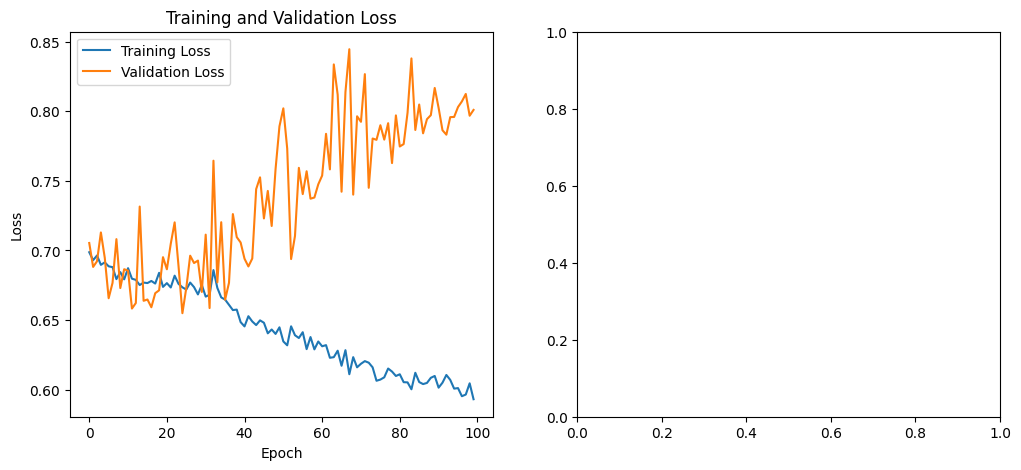

In [13]:
def run_complete_training():
    """Complete pipeline for training and evaluating the DTI model"""
    # Initialize components
    model, trainer, test_loader, test_dataset, tokenizer, device = initialize_training()
    
    # Train model
    best_f1 = trainer.train()
    
    # Evaluate on test set
    test_metrics, test_results = trainer.evaluate_test_set(test_loader)
    
    # Analysis of results
    print("\nAnalyzing results...")
    
    # Find misclassified examples
    misclassified = test_results[test_results['true_label'] != test_results['predicted']]
    print(f"Number of misclassified examples: {len(misclassified)}")
    
    # Find examples where model is most confident but wrong
    if len(misclassified) > 0:
        misclassified['confidence'] = misclassified.apply(
            lambda row: row['probability'] if row['predicted'] == 1 else 1 - row['probability'], 
            axis=1
        )
        
        most_confident_errors = misclassified.sort_values('confidence', ascending=False).head(5)
        print("\nMost confident errors:")
        print(most_confident_errors[['drug_id', 'pdb_id', 'true_label', 'predicted', 'confidence']])
    
    return model, test_metrics, test_results, test_dataset, tokenizer, device

# Call the function to start training
if __name__ == "__main__":
    model, test_metrics, test_results, test_dataset, tokenizer, device = run_complete_training()